In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import math
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Importa o csv com a amostra

In [2]:
case_control_df = pd.read_csv("amostra/data_BR_Match.csv",encoding="utf-8")

### Mapging das variaveis

In [3]:
def categoriza_df_case_control(df):
    """
    Recebe o DataFrame de casos e controles (df_case_control) e retorna um DataFrame 
    com as variáveis categorizadas conforme os mapeamentos e regras definidas.
    """
    # Copia o DataFrame para não modificar o original
    df = df.copy()
    
    # --- Definição dos mapeamentos ---
    estcivmae_mapping = {
        1: 'Solteira',
        2: 'Casada',
        3: 'Viúva',
        4: 'Separada/Divorciada',
        5: 'União Estável',
        9: 'Ignorado'
    }
    
    sexo_mapping = {
        1: 'Masculino',
        2: 'Feminino'
    }
    gravidez_mapping = {
        1: 'Única',
        2: 'Dupla',
        3: 'Tripla ou mais',
        9: 'Ignorado'
    }
    
    escmae2010_mapping = {
        0: 'Sem escolaridade',
        1: 'Fundamental I (1ª a 4ª série)',
        2: 'Fundamental II (5ª a 8ª série)',
        3: 'Médio (antigo 2º Grau)',
        4: 'Superior incompleto',
        5: 'Superior completo',
        9: 'Ignorado'
    }
    
    parto_mapping = {
        1: 'Vaginal',
        2: 'Cesáreo',
        9: 'Ignorado'
    }
    
    cbo_mapping = {
        'Profissionais de Saúde': [
            # Médicos e profissionais de medicina
            221, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 
            # Enfermeiros e afins
            222, 2221, 2222, 2223, 2224, 2235,
            # Farmacêuticos e bioquímicos
            223, 2231, 2232, 2233, 2234, 2236, 
            # Fisioterapeutas e afins
            224, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249,
            # Nutricionistas
            225, 2251, 2252, 2253,
            # Outros profissionais de saúde de nível superior
            226, 2261, 2262, 2263, 2264, 2265, 2266, 2267,
            # Técnicos de saúde
            321, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219,
            322, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229,
            323, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239,
            324, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249,
            # Auxiliares de saúde
            515410, 5151, 5152, 5153, 5155, 5160, 
            # Técnicos em equipamentos médicos
            391, 3911, 3912, 3915, 3916, 3917,
            # Atendentes de farmácia
            5152, 5198, 5199
        ],
        
        'Trabalhadores da Indústria Química e Farmacêutica': [
            # Operadores de instalações químicas
            811, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119,
            # Operadores de máquinas para fabricação de produtos químicos
            812, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129,
            # Operadores de instalações de produção de materiais e produtos farmacêuticos
            813, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139,
            # Operadores de máquinas para fabricação de produtos de borracha e plástico
            814, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149,
            # Outros operadores químicos
            815, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159,
            816, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169,
            818, 8181, 8182, 8183, 8184, 8185, 8186,
            # Trabalhadores de laboratórios químicos e farmacêuticos
            301, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019,
            # Técnicos em química
            311, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119,
            # Farmacêuticos e técnicos em farmácia
            2234, 2235, 3251, 3252, 3253
        ],
        
        'Trabalhadores com Exposição a Solventes e Produtos Tóxicos': [
            # Pintores e aplicadores de revestimentos
            723, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239,
            # Trabalhadores de tinturaria e tratamento químico têxtil
            796, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969,
            # Trabalhadores de galvanoplastia
            728, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289,
            # Operadores da indústria gráfica (exposição a tintas e solventes)
            766, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669,
            # Trabalhadores de fabricação e manutenção de móveis (vernizes, colas)
            771, 7711, 7712, 7713, 7714, 7721, 7731, 7741, 7751, 7761,
            # Operadores de laboratório fotográfico e radiológico
            318, 3181, 3182, 3183, 3184, 3185, 3186,
            # Trabalhadores de curtumes e preparação de couros
            828, 8281, 8282, 8283, 8284, 8285, 8286,
            # Trabalhadores de processamento de madeira e tratamento químico
            773, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 
            # Operadores de máquinas de lavanderia industrial (detergentes, solventes)
            8183, 8184, 8192, 8193,
            # Trabalhadores de limpeza industrial/hospitalar (exposição a produtos químicos fortes)
            5142, 5143, 5192, 5199
        ],
        
        'Trabalhadores com Exposição a Metais Pesados': [
            # Trabalhadores de fundição e forja
            724, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249,
            # Trabalhadores de tratamento térmico de metais
            725, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259,
            # Trabalhadores de soldagem e corte
            7241, 7242, 7243, 7244, 7245, 7246,
            # Operadores de máquinas de usinagem de metais
            721, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219,
            # Trabalhadores metalúrgicos
            722, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229,
            # Operadores de instalações metalúrgicas
            812, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129,
            # Trabalhadores de fabricação de joias e bijuterias (soldas, ligas metálicas)
            7511, 7512, 7513, 7750, 7751, 7752, 7753, 7754, 7755,
            # Trabalhadores de galvanização e revestimento metálico
            7250, 7251, 7252, 7253, 7254, 7255,
            # Encanadores e outros trabalhadores que manipulam solda de chumbo
            7241, 7242, 7243, 7244, 7245, 7246,
            # Técnicos de prótese dentária (mercúrio, ligas metálicas)
            3224, 3225, 3226, 7510, 7511, 7512
        ],
        
        'Trabalhadores com Exposição a Pesticidas e Agroquímicos': [
            # Trabalhadores agrícolas
            611, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119,
            612, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129,
            613, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 
            614, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149,
            # Aplicadores de agrotóxicos
            622, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229,
            # Trabalhadores florestais
            631, 6310, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329,
            # Trabalhadores de controle de pragas urbanas
            5199, 5192, 5193, 5194, 5195, 
            # Técnicos agrícolas
            321, 3211, 3212, 3213, 
            # Engenheiros agrônomos e técnicos em agropecuária
            2221, 2222, 2223, 3211, 3212, 3213,
            # Trabalhadores de armazéns e silos (exposição a grãos tratados)
            7831, 7832, 7833, 7834, 7835, 7836
        ],
        
        'Trabalhadores com Exposição a Radiação': [
            # Técnicos em radiologia médica
            324, 3241, 3242, 3243, 3240,
            # Operadores de equipamentos de raios-X industrial
            3913, 3914, 3915, 3916, 3917, 3918, 3919,
            # Técnicos em medicina nuclear
            3244, 3245, 3246, 3247, 3248, 3249,
            # Técnicos em radioterapia
            3246, 3247, 3248, 3249,
            # Médicos radiologistas
            2231, 2232, 2233, 2234, 2235, 2236,
            # Operadores de equipamentos industriais com fontes radioativas
            3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919,
            # Técnicos em manutenção de equipamentos médicos com radiação
            9153, 9154, 9155, 9156, 9157, 9158, 9159,
            # Trabalhadores da indústria nuclear
            8111, 8112, 8113, 8114, 8115,
            # Pesquisadores e técnicos em laboratórios com fontes radioativas
            2031, 2032, 2033, 2034, 2035, 3111, 3112, 3113, 3114, 3115
        ],
        
        'Profissionais da Beleza e Estética': [
            # Cabeleireiros e especialistas em tratamento de beleza
            512, 5161, 516105, 516110, 516115, 516120, 516125, 516130, 516135,
            # Esteticistas e afins
            516, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169,
            # Manicures, pedicures e afins
            5161, 516140, 516145, 516150,
            # Maquiadores
            516125, 516130, 516135, 516155, 516160, 516165,
            # Massagistas e outros profissionais de tratamentos de beleza
            3221, 3222, 3223, 3224, 5169, 5170, 5171, 5172, 5173, 5174,
            # Tatuadores e aplicadores de piercings (exposição a tintas e metais)
            5169, 5170, 5171, 5172, 5173, 5174, 5175,
            # Operadores de equipamentos de bronzeamento artificial
            5161, 5162, 5163, 5164, 5165
        ],
        
        'Trabalhadores da Construção Civil': [
            # Pedreiros, serventes, etc.
            715, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159,
            # Carpinteiros
            716, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169,
            # Encanadores, eletricistas
            717, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179,
            # Outros trabalhadores da construção
            718, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189,
            719, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199
        ],
        
        'Profissionais da Limpeza e Serviços Domésticos': [
            # Trabalhadores dos serviços domésticos
            511, 5121, 5131, 5132, 5133, 5134, 5135, 5136,
            # Trabalhadores de limpeza
            514, 5142, 5143, 5151, 5152, 
            # Faxineiros e serventes
            515, 5151, 5152, 5153, 5154, 5141, 5142, 5143, 5144
        ],
        
        'Trabalhadoras do Comércio e Serviços': [
            # Vendedores e demonstradores em lojas
            521, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219,
            # Caixas e atendentes
            422, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229,
            # Recepcionistas e afins
            422, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229,
            # Garçons e atendentes de bar
            513, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139
        ],
        
        'Trabalhadoras de Escritório e Administrativas': [
            # Secretárias e auxiliares administrativos
            411, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119,
            # Auxiliares de contabilidade e afins
            413, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139,
            # Auxiliares de escritório
            414, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149,
            # Operadores de equipamentos de escritório
            415, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159
        ],
        
        'Professoras e Educadoras': [
            # Professores de nível superior
            231, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319,
            232, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329,
            233, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339,
            234, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349,
            # Professores de nível médio
            331, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319,
            332, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329,
            # Auxiliares de educação infantil
            333, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339
        ],
        
        'Profissionais de Alimentação': [
            # Cozinheiros e auxiliares de cozinha
            513, 5131, 5132, 5133, 5134, 5135, 5136,
            # Padeiros, confeiteiros e afins
            848, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489,
            # Trabalhadores na fabricação de alimentos
            841, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419,
            842, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429
        ],
        
        'Sem informação/desempregada': [999, 0, 998, 997, '', None]
    }
    
    # --- Funções auxiliares ---
    def categoriza_ocupacao(codigo):
        # Tratar valores vazios e NaN
        if pd.isna(codigo) or codigo == '':
            return 'Sem informação/desempregada'
        try:
            codigo = int(codigo)  # converte para inteiro
            for categoria, codigos in cbo_mapping.items():
                if codigo in codigos:
                    return categoria
            return 'Outras ocupações'
        except ValueError:
            return 'Sem informação/desempregada'
    
    def categoriza_variaveis(df):
        # Colunas a serem tratadas: converte para string, substitui vazios e converte para int com NaNs tratados
        colunas = ['ESTCIVMAE', 'GRAVIDEZ', 'ESCMAE2010', 'PARTO']
        for col in colunas:
            df[col] = df[col].astype(str)
            df[col] = df[col].replace({'': np.nan, 'nan': np.nan})
            df[col] = df[col].astype(float).fillna(9).astype(int)
        
        # Aplicando os mapeamentos
        df['ESTCIVMAE_CAT'] = df['ESTCIVMAE'].apply(lambda x: estcivmae_mapping.get(x, 'Desconhecido'))
        df['GRAVIDEZ_CAT'] = df['GRAVIDEZ'].replace(gravidez_mapping)
        df['ESCMAE2010_CAT'] = df['ESCMAE2010'].replace(escmae2010_mapping)
        df['PARTO_CAT'] = df['PARTO'].replace(parto_mapping)
        df['SEXO_CAT'] = df['SEXO'].replace(sexo_mapping)
        return df

    # --- Categorização das variáveis do DataFrame ---
    # Categoriza IDADEMAE (<30, ≥30 anos)
    df['IDADEMAE_CAT'] = np.where(df['IDADEMAE'] < 30, '<30', '≥30')
    
    # Categoriza PESO (peso ao nascer: <3000g, ≥3000g)
    df['PESO_CAT'] = np.where(df['PESO'] < 3000, '<3000g', '≥3000g')
    df['QTDFILMORT_CAT'] = np.where(df['QTDFILMORT'] == 0, '0',
                                    np.where(df['QTDFILMORT'].between(1, 2), '1-2', '3+'))
    # Categoriza SEMAGESTAC (<37, 37-40, >40 semanas)
    df['SEMAGESTAC_CAT'] = pd.cut(
        df['SEMAGESTAC'],
        bins=[0, 37, 40, np.inf],
        labels=['<37', '37-40', '>40']
    )
    
    # Categoriza CONSULTAS conforme as faixas definidas
    consultas_malf_mapping = {
        1: 'Nenhuma',
        2: '1 a 3',
        3: '4 a 6',
        4: '7 e mais',
        9: 'ignorado'
    }

    df['CONSULTAS_CAT'] = df['CONSULTAS'].replace(consultas_malf_mapping)
    # Categoriza a ocupação materna usando a função auxiliar
    df['CODOCUPMAE_CAT'] = df['CODOCUPMAE'].apply(categoriza_ocupacao)
    
    # Aplica a categorização de variáveis com mapeamentos para ESTCIVMAE, GRAVIDEZ, ESCMAE2010 e PARTO
    df = categoriza_variaveis(df)
    
    return df

In [4]:
df_categorizado = categoriza_df_case_control(case_control_df)

# table 1

In [21]:
def build_table1(df, variables, outcome='CARDIAC'):
    """
    Constrói a Table 1 com distribuições de frequências (n (%))
    para cada categoria de variáveis categóricas, separando por grupo:
    - Controles (outcome == 0)
    - Casos (outcome == 1)
    Também retorna os totais gerais.
    """
    # Totais gerais
    total = df.shape[0]
    total_controls = df[df[outcome] == 0].shape[0]
    total_cases = df[df[outcome] == 1].shape[0]
    
    summary_list = []
    
    # Mapeamento para exibição de nomes amigáveis
    variable_mapping = {
        'IDADEMAE_CAT': 'Idade Materna',
        'GRAVIDEZ_CAT': 'Tipo de Gravidez',
        'PESO_CAT':'Peso ao Nascer',
        'SEMAGESTAC_CAT':'Semanas de Gestação',
        'CONSULTAS_CAT':'Número de Consultas Pré-Natal',
        'CODOCUPMAE_CAT':'Ocupação da Mãe',
        'ESTCIVMAE_CAT':'Estado Civil da Mãe',
        'PARTO_CAT':'Tipo de Parto',
        'ESCMAE2010_CAT':'Escolaridade materna',
        #'OTHER_MALF_CAT':'Presença de Outras Mal-Formações',
        'SEXO_CAT': 'Sexo do bebe',
        'QTDFILMORT_CAT': 'Quantidade de Filhos Mortos'
    }
    
    for var in variables:
        # Usa o nome mapeado se existir, senão mantém o nome original
        display_var = variable_mapping.get(var, var)
        
        # Cria a tabela de contingência para a variável e o desfecho
        ct = pd.crosstab(df[var], df[outcome])
        for cat in ct.index:
            # Recupera as contagens para cada grupo (se a coluna não existir, assume 0)
            control_count = ct.loc[cat, 0] if 0 in ct.columns else 0
            case_count = ct.loc[cat, 1] if 1 in ct.columns else 0
            total_count = control_count + case_count
            
            # Calcula os percentuais (em relação ao total de cada grupo)
            perc_control = (control_count / total_controls * 100) if total_controls > 0 else 0
            perc_case = (case_count / total_cases * 100) if total_cases > 0 else 0
            perc_total = (total_count / total * 100) if total > 0 else 0
            
            summary_list.append({
                'Variável': display_var,
                'Categoria': cat,
                'Controles n (%)': f'{control_count} ({perc_control:.1f}%)',
                'Casos n (%)': f'{case_count} ({perc_case:.1f}%)',
                'Total n (%)': f'{total_count} ({perc_total:.1f}%)'
            })
    
    table1_df = pd.DataFrame(summary_list)
    return table1_df, total, total_controls, total_cases

In [23]:
# Lista das variáveis categóricas para a Table 1
variaveis = [
    'PESO_CAT',
    'IDADEMAE_CAT',
    'SEMAGESTAC_CAT',
    'CONSULTAS_CAT',
    'CODOCUPMAE_CAT',
    'GRAVIDEZ_CAT',
    'ESTCIVMAE_CAT',
    'PARTO_CAT',
    'ESCMAE2010_CAT',
    #'OTHER_MALF_CAT',
    'SEXO_CAT',
    'QTDFILMORT',
]
# Supondo que seu dataframe se chame df_quiquadrado e que a variável de desfecho seja 'CARDIAC'
table1_df, total, total_controls, total_cases = build_table1(df_categorizado, variaveis, outcome='CARDIAC')

# Exibe os totais gerais
print("Total de casos analisados:")
print(f"Total: {total}")
print(f"Controles: {total_controls}")
print(f"Casos: {total_cases}\n")

# Exibe a Table 1
print("Table 1 - Distribuições de Frequências das Características Maternas e Perinatais:")
table1_df.to_csv("output/table1-CasoxControle.csv")
#table1_df

Total de casos analisados:
Total: 15520
Controles: 12416
Casos: 3104

Table 1 - Distribuições de Frequências das Características Maternas e Perinatais:


#### table 2

In [ ]:
# Função para Table 1 – Variáveis Contínuas
def build_table1_continuous(df, variables, outcome='CARDIAC'):
    total = df.shape[0]
    total_controls = df[df[outcome] == 0].shape[0]
    total_cases = df[df[outcome] == 1].shape[0]
    
    summary_list = []
    for var in variables:
        # Calcula média e desvio padrão para cada grupo
        overall_mean = df[var].mean()
        overall_sd = df[var].std()
        controls_mean = df.loc[df[outcome] == 0, var].mean()
        controls_sd = df.loc[df[outcome] == 0, var].std()
        cases_mean = df.loc[df[outcome] == 1, var].mean()
        cases_sd = df.loc[df[outcome] == 1, var].std()
        
        summary_list.append({
            'Variável': var,
            'Controles (média ± DP)': f'{controls_mean:.2f} ± {controls_sd:.2f}',
            'Casos (média ± DP)': f'{cases_mean:.2f} ± {cases_sd:.2f}',
            'Total (média ± DP)': f'{overall_mean:.2f} ± {overall_sd:.2f}'
        })
    table_cont = pd.DataFrame(summary_list)
    return table_cont, total, total_controls, total_cases

# Lista das variáveis categóricas (já categorizadas)
variaveis = [
    'PESO_CAT',
    'IDADEMAE_CAT',
    'SEMAGESTAC_CAT',
    'CONSULTAS_CAT',
    'CODOCUPMAE_CAT',
    'GRAVIDEZ_CAT',
    'ESTCIVMAE_CAT',
    'PARTO_CAT',
    'ESCMAE2010_CAT',
    #'OTHER_MALF_CAT',
    'SEXO_CAT'
]

# Lista das variáveis contínuas
continuous_vars = [
    'PESO',
    'IDADEMAE',  # Se a variável for diferente de IDADEMAE, utilize o nome correto
    'SEMAGESTAC',
    'QTDFILMORT'
]


In [27]:
# Supondo que seu DataFrame se chame df_quiquadrado e o desfecho seja definido em 'CARDIAC'
table1_cont, _, _, _ = build_table1_continuous(df_categorizado, continuous_vars, outcome='CARDIAC')

# Exibe os totais gerais
print("Total de casos analisados:")
print(f"Total: {total}")
print(f"Controles: {total_controls}")
print(f"Casos: {total_cases}\n")

print("\nTable 2 - Variáveis Contínuas (mean ± SD):")
table1_cont.to_csv("output/table2-Descricaodosgruposporvariaveiscontinuas.csv")

Total de casos analisados:
Total: 15520
Controles: 12416
Casos: 3104


Table 2 - Variáveis Contínuas (mean ± SD):


#### table 3

In [24]:
def build_table3(df, variables, outcome='CARDIAC'):
    """
    Gera a Table 2 com os resultados do teste de Qui‑Quadrado para as variáveis categóricas.
    
    Para cada variável, calcula:
      - A tabela de contingência (variável x outcome)
      - O teste de Qui‑Quadrado (valor de χ², graus de liberdade e p‑valor)
      - Para cada categoria, a contagem e a proporção (n e % no total)
    
    Retorna um DataFrame com as colunas:
      Variável, Categoria, Resultado do Teste, Proporção, p‑valor
    """
    total = df.shape[0]
    summary_list = []
    
    for var in variables:
        # Cria a tabela de contingência entre a variável e o desfecho
        ct = pd.crosstab(df[var], df[outcome])
        try:
            chi2, p, dof, _ = chi2_contingency(ct)
        except Exception as e:
            chi2, p, dof = np.nan, np.nan, np.nan
        
        # Formata o resultado do teste (aplica o mesmo para todas as categorias da variável)
        resultado_teste = f"χ²={chi2:.2f} (df={dof})" if not np.isnan(chi2) else "NA"
                # Formata o resultado do teste e o p-valor (adicionando * para p < 0.05)
        p_valor = f"{p:.3f}" if not np.isnan(p) else "NA"
        p_valor = ">0.001" if p<0.001 else p_valor
        
        if not np.isnan(p):
            var = f"{var}" + ("*" if p < 0.05 else "")
          
        else:
            p_valor = "NA"
        
        # Para cada categoria da variável
        for cat in ct.index:
            # Número de casos nessa categoria (assumindo que outcome == 1 é caso)
            case_count = ct.loc[cat, 1] if 1 in ct.columns else 0
            # Total na categoria (soma de casos e controles)
            total_cat = ct.loc[cat].sum()
            # Proporção de casos dentro da categoria (em %)
            prop_cases = (case_count / total_cat * 100) if total_cat > 0 else 0
            
            summary_list.append({
                "Variável": var,
                "Categoria": cat,
                "Resultado do Teste": resultado_teste,
                "Proporção de Casos": f"{case_count} ({prop_cases:.1f}%)",
                "p‑valor": p_valor
            })
    
    table3_df = pd.DataFrame(summary_list)
    return table3_df

In [25]:
categorical_vars = [
    'PESO_CAT',
    #'IDADEMAE_CAT',
    #'SEMAGESTAC_CAT',
    'CONSULTAS_CAT',
    'CODOCUPMAE_CAT',
    'GRAVIDEZ_CAT',
    'ESTCIVMAE_CAT',
    #'PARTO_CAT',
    'ESCMAE2010_CAT',
    #'OTHER_MALF_CAT',
    'SEXO_CAT',
    'QTDFILMORT_CAT'
]


In [26]:
# Supondo que seu DataFrame se chame df_quiquadrado e o desfecho esteja na coluna 'CARDIAC'
table3_df = build_table3(df_categorizado, categorical_vars, outcome='CARDIAC')

# Exibe a Table 2
print("Table 3 - Resultados do Teste de Qui‑Quadrado para Variáveis Categóricas")
#table3_df.to_excel("outputs/table3-ResultadosdoTesteQui‑Quadrado.xlsx")
table3_df.to_csv("output/table3-quiquadrado.csv")

Table 3 - Resultados do Teste de Qui‑Quadrado para Variáveis Categóricas


### table 4

In [28]:
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [29]:
def build_table4(df, categorical_vars, outcome='CARDIAC'):
    """
    Calcula os Odds Ratios (OR) com IC 95% para cada variável categórica usando regressão logística.
    Para cada variável, o modelo é ajustado como: outcome ~ C(variável)
    
    Retorna um DataFrame com as colunas:
      - Variável
      - Categoria
      - Odds Ratio
      - IC 95% Lower
      - IC 95% Upper
      - p-value
    """
    results_list = []
    
    # Parâmetros para a otimização robusta
    opt_kwargs = {'method': 'lbfgs', 'maxiter': 1000, 'disp': 0}
    
    for var in categorical_vars:
        formula = f"{outcome} ~ C({var})"
        try:
            # Captura warnings de convergência
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always", ConvergenceWarning)
                model = smf.logit(formula, data=df).fit(**opt_kwargs)
                # Se houver algum ConvergenceWarning, informe no log
                for warning in w:
                    if issubclass(warning.category, ConvergenceWarning):
                        print(f"ConvergenceWarning para {var}: {warning.message}. mle_retvals: {model.mle_retvals}")
                        
            params = model.params
            conf = model.conf_int()
            pvalues = model.pvalues
            
            # Obtém as categorias únicas (ignorando NaNs) e ordena
            cats = sorted(df[var].dropna().unique())
            # Define a primeira categoria como referência
            ref = cats[0]
            results_list.append({
                "Variável": var,
                "Categoria": ref,
                "Odds Ratio": 1.0,
                "IC 95% Lower": 1.0,
                "IC 95% Upper": 1.0,
                "p-value": np.nan  # A categoria de referência não possui p-valor
            })
            
            # Para as demais categorias, a nomenclatura no modelo é: C(var)[T.<categoria>]
            for cat in cats[1:]:
                coef_name = f"C({var})[T.{cat}]"
                if coef_name in params.index:
                    coef = params[coef_name]
                    OR = np.exp(coef)
                    # Aplica clip nos limites do intervalo para evitar overflow; 
                    # valores muito altos ou baixos podem ser limitados a um range razoável.
                    lower_bound = np.clip(conf.loc[coef_name, 0], -700, 700)
                    upper_bound = np.clip(conf.loc[coef_name, 1], -700, 700)
                    ci_lower = np.exp(lower_bound)
                    ci_upper = np.exp(upper_bound)
                    p_val = pvalues[coef_name]
                    p_val_str = "<0.0001" if p_val < 0.0001 else f"{p_val:.3f}"
                    results_list.append({
                        "Variável": var,
                        "Categoria": cat,
                        "Odds Ratio": OR,
                        "IC 95% Lower": ci_lower,
                        "IC 95% Upper": ci_upper,
                        "Odds Ratio IC": f"{OR:.3f} [{ci_lower:.3f} - {ci_upper:.3f} ]",
                        "p-value": p_val_str
                    })
        except Exception as e:
            print(f"Erro ao processar a variável {var}: {e}")
    
    table4_df = pd.DataFrame(results_list)
    return table4_df


In [30]:
def forest_plot_by_variable(table3_df):
    """
    Gera um forest plot para cada variável categórica (exceto as categorias "Ignorado")
    usando subplots. Para cada variável, plota os Odds Ratios (com IC 95%) de suas categorias.
    """
    # Remove as linhas em que a categoria seja "Ignorado"
    df_plot = table3_df[table3_df["Categoria"] != "Ignorado"].copy()
    
    # Obtém as variáveis únicas
    unique_vars = df_plot["Variável"].unique()
    n_vars = len(unique_vars)
    
    # Define a disposição dos subplots: se houver mais de 4 variáveis, usamos duas colunas
    if n_vars > 4:
        ncols = 2
        nrows = math.ceil(n_vars / ncols)
    else:
        ncols = 1
        nrows = n_vars
        
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 2.5))
    
    # Se houver apenas um subplot, forçamos axes a ser uma lista
    if n_vars == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()
    
    # Para cada variável, filtramos os dados e plotamos
    for idx, var in enumerate(unique_vars):
        ax = axes[idx]
        # Filtra o DataFrame para a variável corrente
        df_var = df_plot[df_plot["Variável"] == var].copy().reset_index(drop=True)
        
        # Converte os Odds Ratios e intervalos para float
        ORs = df_var["Odds Ratio"].astype(float)
        ci_lower = df_var["IC 95% Lower"].astype(float)
        ci_upper = df_var["IC 95% Upper"].astype(float)
        
        # Calcula os logaritmos (para plotar na escala logarítmica)
        log_ORs = np.log(ORs)
        log_ci_lower = np.log(ci_lower)
        log_ci_upper = np.log(ci_upper)
        error_lower = log_ORs - log_ci_lower
        error_upper = log_ci_upper - log_ORs
        
        # Define as posições no eixo y para cada categoria desta variável
        y_positions = np.arange(len(df_var))
        
        # Plota os pontos com barras de erro
        ax.errorbar(log_ORs, y_positions, xerr=[error_lower, error_upper],
                    fmt='o', color='black', ecolor='black', capsize=4)
        # Linha de referência em log(1)=0 (OR=1)
        ax.axvline(x=0, color='red', linestyle='--')
        
        # Rótulos do eixo y com os nomes das categorias
        ax.set_yticks(y_positions)
        ax.set_yticklabels(df_var["Categoria"])
        ax.set_title(f"{var}")
        
        # Define os ticks do eixo x (na escala log) e os rótulos com os ORs originais
        ticks = np.array([0.1, 0.5, 1, 2, 5, 10])
        ax.set_xticks(np.log(ticks))
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Odds Ratio")
    
    # Se houver subplots extras (caso o grid seja maior), os desativa
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

Table 4 - Odds Ratios (IC 95%) para Variáveis Categóricas


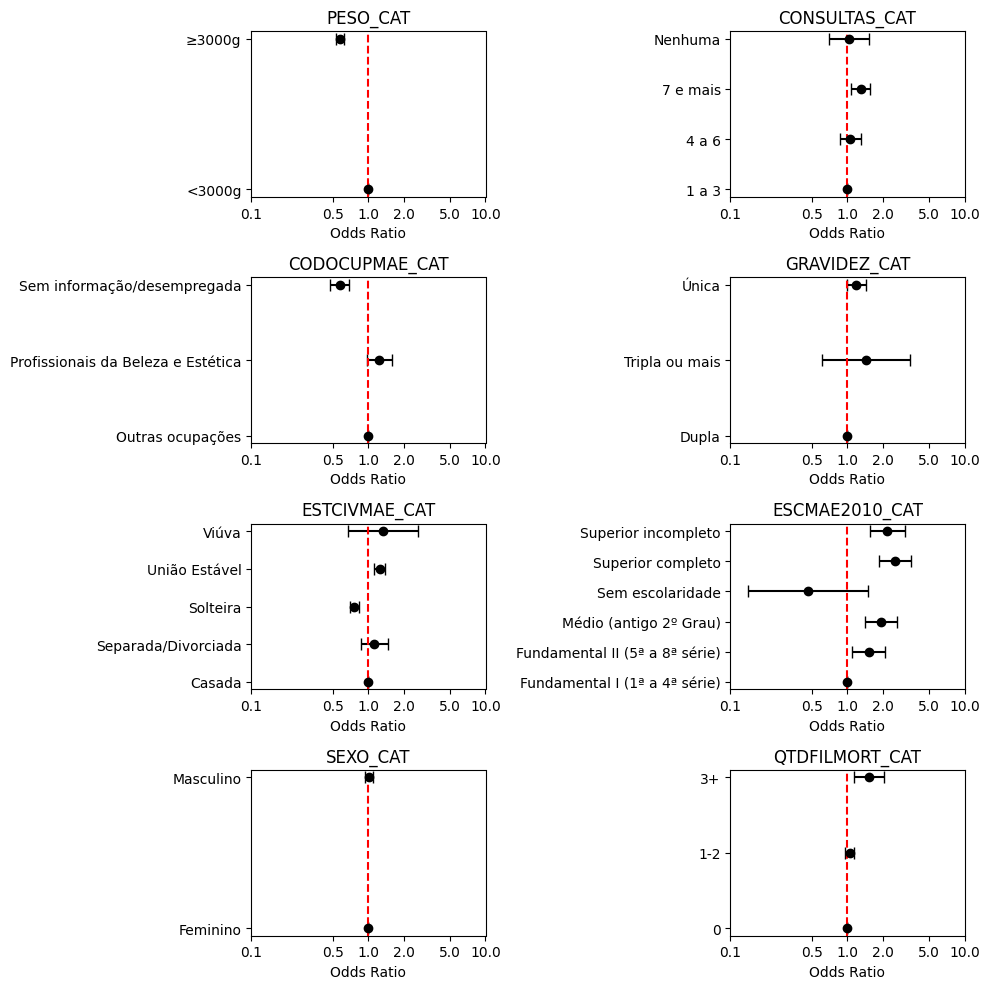

In [31]:
# Supondo que o DataFrame se chame df_quiquadrado e o desfecho seja a variável 'CARDIAC'
table4_df = build_table4(df_categorizado, categorical_vars, outcome='CARDIAC')

# Exibe a Table 3
print("Table 4 - Odds Ratios (IC 95%) para Variáveis Categóricas")

table4_df.to_csv("output/table4-ORCat.csv")
# Gera o Forest Plot
# Exemplo de uso (supondo que 'table3_df' já tenha sido gerada pela função build_table3):
forest_plot_by_variable(table4_df)

# Regressao logistica

In [6]:
# Bibliotecas para o pipeline e avaliação
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
# Biblioteca para statsmodels (inferência)
import statsmodels.api as sm

In [15]:
df_model_scaled = case_control_df.copy()
df_model_scaled['PESO_500'] = df_model_scaled['PESO'] / 500

# Seleciona as variáveis independentes (X) e a dependente (y)
X = df_model_scaled[['QTDFILMORT', 'PESO_500']]  # Adiciona PESO_500 como variável independente
y = df_model_scaled['CARDIAC']

# Converte as variáveis para numérico (caso ainda não estejam)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Remove linhas com NaN ou valores infinitos
data = pd.concat([X, y.rename('y')], axis=1)
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data[['QTDFILMORT', 'PESO_500']]
y = data['y']

# Adiciona a constante para o modelo (intercepto)
X_sm = sm.add_constant(X).astype(float)
y = y.astype(float)

# Ajusta o modelo de regressão logística usando statsmodels
model_sm = sm.Logit(y, X_sm).fit(disp=0)

print(model_sm.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                15519
Model:                          Logit   Df Residuals:                    15516
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                 0.01404
Time:                        13:41:22   Log-Likelihood:                -7657.0
converged:                       True   LL-Null:                       -7766.0
Covariance Type:            nonrobust   LLR p-value:                 4.437e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2952      0.077     -3.841      0.000      -0.446      -0.145
QTDFILMORT     0.0409      0.030      1.378      0.168      -0.017       0.099
PESO_500      -0.1923      0.013    -14.788      0.0

In [16]:
# Extração dos resultados do modelo ajustado com statsmodels (model_sm)
coef = model_sm.params
conf_int = model_sm.conf_int()
pvalues = model_sm.pvalues

# Calcula os Odds Ratios e os intervalos de confiança para os Odds Ratios
or_values = np.exp(coef)
or_ci_lower = np.exp(conf_int[0])
or_ci_upper = np.exp(conf_int[1])

# Cria um DataFrame com os resultados
results_df = pd.DataFrame({
    'Feature': coef.index,
    'Coefficient': coef.values,
    'Odds Ratio': or_values.values,
    'IC 95% Lower': or_ci_lower.values,
    'IC 95% Upper': or_ci_upper.values,
    'Odds Ratio IC': [f"{or_val:.3f} [{ci_low:.3f} - {ci_up:.3f}]" 
                      for or_val, ci_low, ci_up in zip(or_values, or_ci_lower, or_ci_upper)],
    'p-value': pvalues.values
})


In [12]:
results_df

,Feature,Coefficient,Odds Ratio,IC 95% Lower,IC 95% Upper,Odds Ratio IC,p-value
0,const,-0.295217,0.744370,0.640276,0.865386,0.744 [0.640 - 0.865],1.224861e-04
1,QTDFILMORT,0.040854,1.041700,0.982895,1.104022,1.042 [0.983 - 1.104],1.681956e-01
2,PESO_500,-0.192313,0.825048,0.804284,0.846348,0.825 [0.804 - 0.846],1.757739e-49


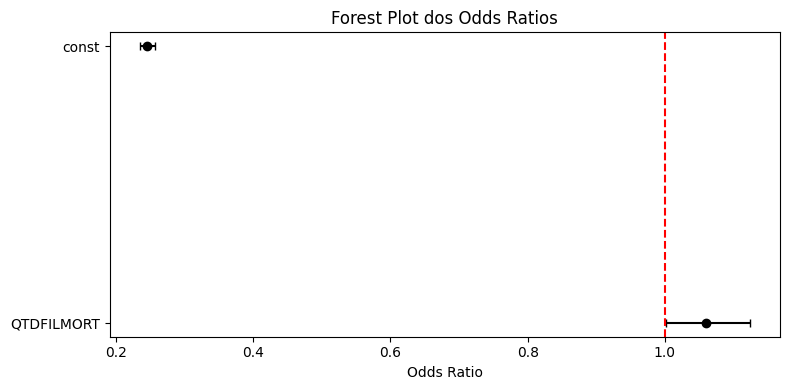

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Opcional: ordenar os resultados para melhorar a visualização (por exemplo, por Odds Ratio)
results_df = results_df.sort_values(by='Odds Ratio')

# Define as variáveis para o plot
features = results_df['Feature']
or_values = results_df['Odds Ratio']
ci_lower = results_df['IC 95% Lower']
ci_upper = results_df['IC 95% Upper']

# Calcula as posições no eixo y
y_pos = np.arange(len(features))

# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(8, 4))

# Plota os Odds Ratios com barras de erro representando os intervalos de confiança
ax.errorbar(
    or_values, y_pos,
    xerr=[or_values - ci_lower, ci_upper - or_values],
    fmt='o', color='black', ecolor='black', capsize=3
)

# Adiciona uma linha vertical de referência em OR = 1
ax.axvline(x=1, color='red', linestyle='--')

# Configura os rótulos do eixo y com o nome das variáveis
ax.set_yticks(y_pos)
ax.set_yticklabels(features)

ax.set_xlabel('Odds Ratio')
ax.set_title('Forest Plot dos Odds Ratios')

# Inverte o eixo y para que a primeira variável fique no topo
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [17]:
from graphviz import Digraph

def create_prisma_flowchart(filename='prisma_flowchart'):
    # Create a new directed graph
    dot = Digraph(comment='PRISMA Flowchart')
    dot.attr(rankdir='TB')  # Top to Bottom direction
    
    # Define node style
    dot.attr('node', shape='box', style='filled', fillcolor='white')
    
    # Add main nodes
    dot.node('A', 'Initial population\nn=2,561,922 live births')
    dot.node('C', 'Valid records\nn=2,464,019')
    dot.node('B', 'Missing data\nn=97,903')
    
    dot.node('D', 'Group with outcome\nn=3,110')
    dot.node('E', 'Group without outcome\nn=2,460,909')
    
    dot.node('F', 'Inadequate gestational intervals\nn=6')
    dot.node('G', 'Final case group\nn=3,104')
    
    dot.node('H', 'Random selection\nmatching by IM and SG\nRatio 1:4')
    dot.node('I', 'Control group\nn=12,416')
    
    dot.node('J', 'Final total sample\nn=15,520')
    
    # Add connections
    dot.edge('A', 'C')
    dot.edge('A', 'B')
    
    dot.edge('C', 'D')
    dot.edge('C', 'E')
    
    dot.edge('D', 'G')
    dot.edge('D', 'F')
    
    dot.edge('E', 'H')
    dot.edge('H', 'I')
    
    dot.edge('G', 'J')
    dot.edge('I', 'J')
    
    # Save the file
    #dot.render(filename, format='pdf', cleanup=True)
    dot.render(filename, format='png', cleanup=True)

# Create the flowchart

create_prisma_flowchart()
